In [ ]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Job/data/copy_sentiment140.csv', encoding='latin1', header=None)

# Assign column names
data.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']

# Sample a fraction of the data, e.g., 33%
fraction = 0.1
data = data.sample(frac=fraction, random_state=42)

# Display the first few rows of the dataset
data.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,target,ids,date,flag,user,text
541200,0,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!
750,0,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo..."
766711,0,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...
285055,0,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...
705995,0,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem


# Preprocessing and Lemmatization

In [ ]:
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to get wordnet POS tag
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Advanced preprocessing function
def preprocess_text_advanced(text):
    # Remove URLs, mentions, and hashtags
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    # Remove punctuation and lowercase the text
    text = re.sub(r'[^\w\s]', '', text.lower())
    # Tokenize and POS tag
    words = nltk.word_tokenize(text)
    words_pos = nltk.pos_tag(words)
    # Lemmatize based on POS tags and remove stopwords
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in words_pos if word not in stop_words]
    return ' '.join(lemmatized_words)

# Apply the advanced preprocessing to the text column
data['cleaned_text_advanced'] = data['text'].apply(preprocess_text_advanced)

# Convert target values (0, 4) to binary (0, 1)
data['target'] = data['target'].apply(lambda x: 0 if x == 0 else 1)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Feature Extraction using TF-IDF

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_text_advanced'], data['target'], test_size=0.2, random_state=42)

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

# Fit and transform the training data, transform the test data
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Display the shape of the TF-IDF matrices
X_train_tfidf.shape, X_test_tfidf.shape


((128000, 10000), (32000, 10000))

# Model Building and Training

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize Logistic Regression model
model = LogisticRegression(max_iter=1000, solver='liblinear', C=1.0)

# Train the model
model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.7726875
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.75      0.77     15878
           1       0.76      0.79      0.78     16122

    accuracy                           0.77     32000
   macro avg       0.77      0.77      0.77     32000
weighted avg       0.77      0.77      0.77     32000

Confusion Matrix:
 [[11925  3953]
 [ 3321 12801]]


# Advanced Techniques: Cross-Validation and Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [500, 1000],
    'penalty': ['l2']  # L2 regularization for lbfgs
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train_tfidf, y_train)

# Display the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Train the final model with the best parameters
final_model = grid_search.best_estimator_
final_model.fit(X_train_tfidf, y_train)

# Evaluate the final model
y_pred_final = final_model.predict(X_test_tfidf)
print(f"Final Model Accuracy: {accuracy_score(y_test, y_pred_final)}")
print("Final Model Classification Report:\n", classification_report(y_test, y_pred_final))
print("Final Model Confusion Matrix:\n", confusion_matrix(y_test, y_pred_final))


Best Parameters: {'C': 1, 'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear'}
Best Cross-Validation Accuracy: 0.7685390624999999
Final Model Accuracy: 0.7726875
Final Model Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.75      0.77     15878
           1       0.76      0.79      0.78     16122

    accuracy                           0.77     32000
   macro avg       0.77      0.77      0.77     32000
weighted avg       0.77      0.77      0.77     32000

Final Model Confusion Matrix:
 [[11925  3953]
 [ 3321 12801]]


# Model Interpretation and Visualization

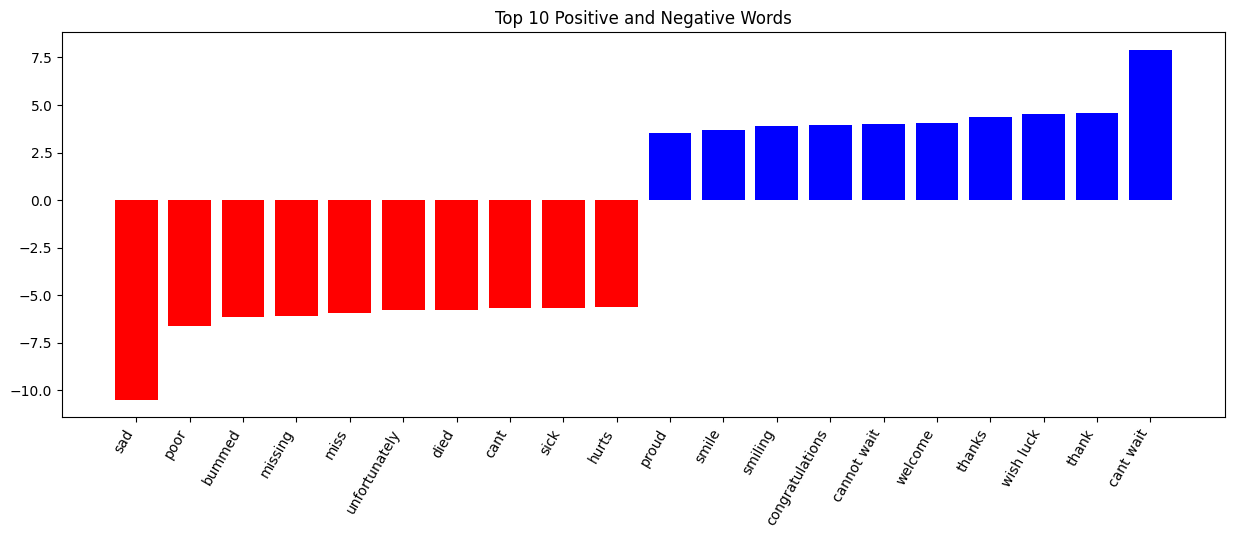

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract feature names and coefficients
feature_names = np.array(tfidf.get_feature_names_out())
coefficients = final_model.coef_.flatten()

# Get top positive and negative features
top_positive_coefficients = np.argsort(coefficients)[-10:]
top_negative_coefficients = np.argsort(coefficients)[:10]
top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])

# Create bar chart
plt.figure(figsize=(15, 5))
colors = ['red' if c < 0 else 'blue' for c in coefficients[top_coefficients]]
plt.bar(np.arange(20), coefficients[top_coefficients], color=colors)
plt.xticks(np.arange(20), feature_names[top_coefficients], rotation=60, ha='right')
plt.title("Top 10 Positive and Negative Words")
plt.show()


# Libraries

## Distribution of Sentiments

<ipython-input-9-175b909d8a53>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=data, palette='viridis')


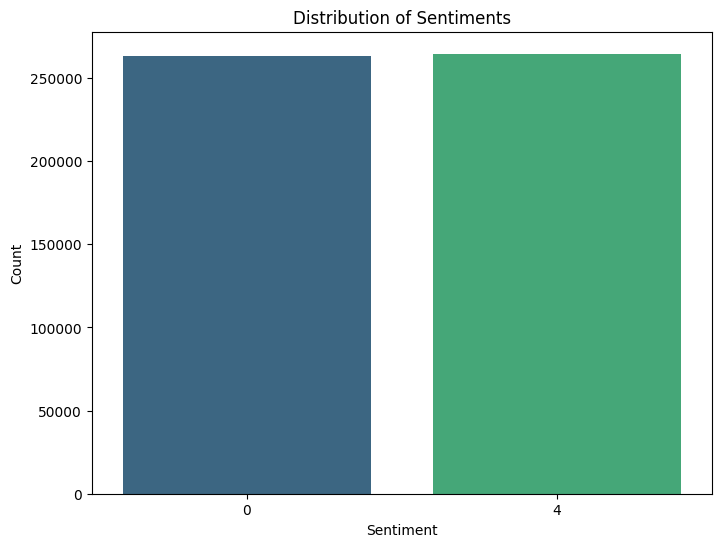

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of Sentiments
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=data, palette='viridis')
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


## Word Cloud for Each Sentiment

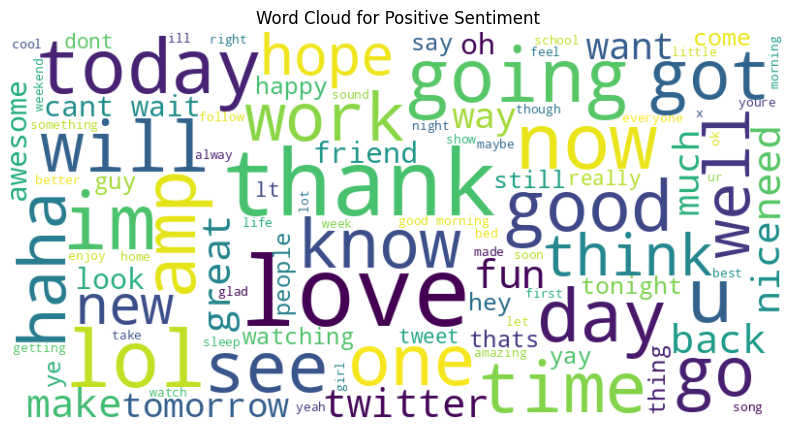

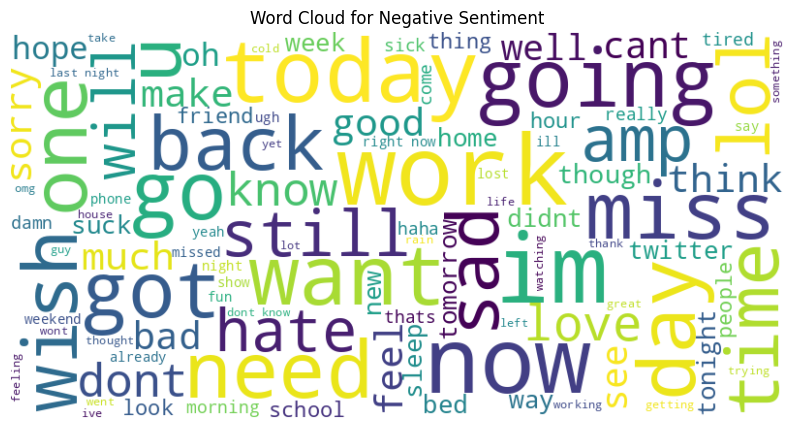

In [ ]:
from wordcloud import WordCloud

# Word Cloud for Positive Sentiment
positive_text = ' '.join(data[data['target'] == 4]['clean_text'])
wordcloud = WordCloud(width=800, height=400, max_font_size=100, max_words=100, background_color='white').generate(positive_text)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Positive Sentiment')
plt.axis('off')
plt.show()

# Word Cloud for Negative Sentiment
negative_text = ' '.join(data[data['target'] == 0]['clean_text'])
wordcloud = WordCloud(width=800, height=400, max_font_size=100, max_words=100, background_color='white').generate(negative_text)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Negative Sentiment')
plt.axis('off')
plt.show()


## Length Distribution of Tweets

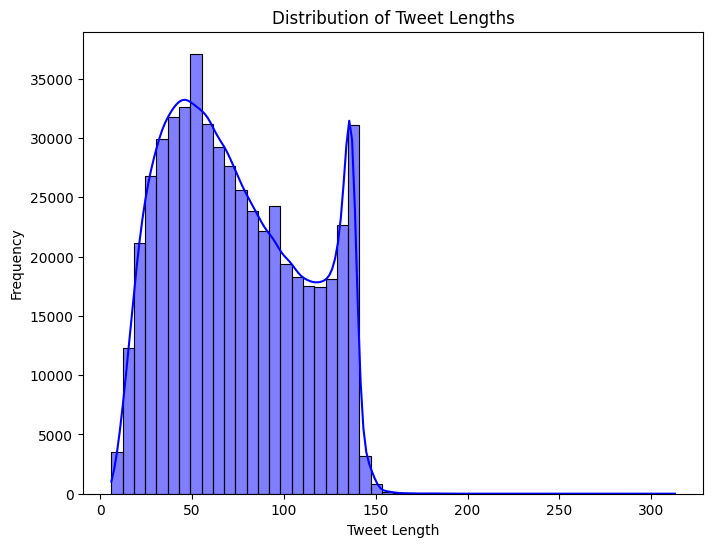

In [ ]:
# Length Distribution of Tweets
data['text_length'] = data['text'].apply(len)
plt.figure(figsize=(8, 6))
sns.histplot(data['text_length'], bins=50, kde=True, color='blue')
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()


## Most Frequent Words in Each Sentiment Category

<ipython-input-12-185e68021ec9>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette='viridis')


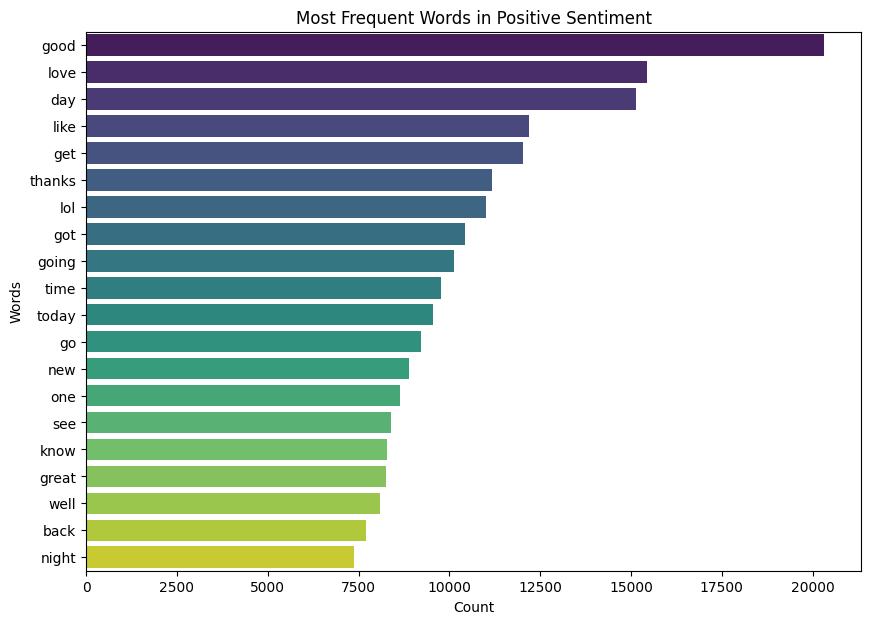

<ipython-input-12-185e68021ec9>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=words, palette='viridis')


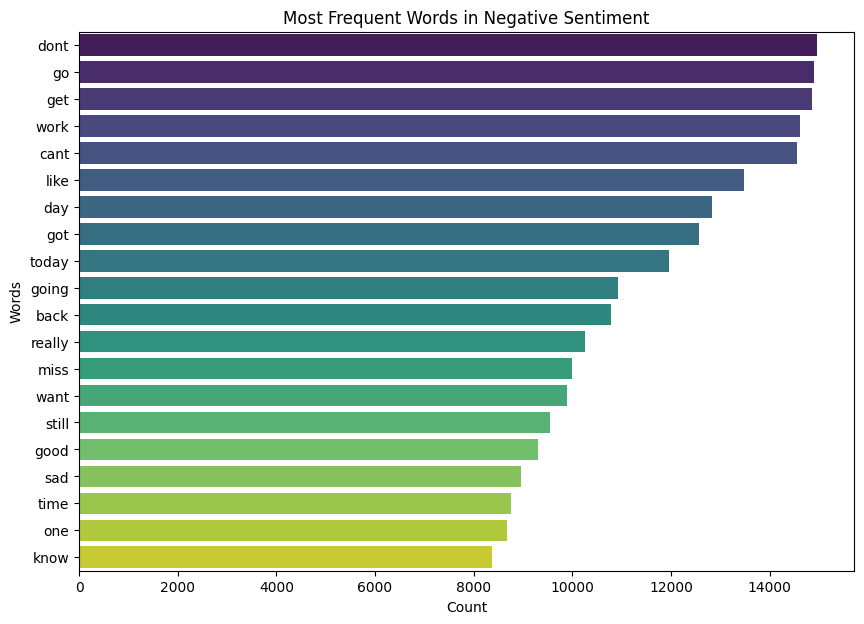

In [ ]:
from collections import Counter

# Function to get the most frequent words
def get_most_frequent_words(tokens, n=20):
    counter = Counter(tokens)
    most_common = counter.most_common(n)
    words, counts = zip(*most_common)
    return words, counts

# Most Frequent Words in Positive Sentiment
positive_tokens = [token for tokens in data[data['target'] == 4]['tokens'] for token in tokens]
words, counts = get_most_frequent_words(positive_tokens)
plt.figure(figsize=(10, 7))
sns.barplot(x=counts, y=words, palette='viridis')
plt.title('Most Frequent Words in Positive Sentiment')
plt.xlabel('Count')
plt.ylabel('Words')
plt.show()

# Most Frequent Words in Negative Sentiment
negative_tokens = [token for tokens in data[data['target'] == 0]['tokens'] for token in tokens]
words, counts = get_most_frequent_words(negative_tokens)
plt.figure(figsize=(10, 7))
sns.barplot(x=counts, y=words, palette='viridis')
plt.title('Most Frequent Words in Negative Sentiment')
plt.xlabel('Count')
plt.ylabel('Words')
plt.show()


## Confusion Matrix Heatmap

In [ ]:
# Confusion Matrix for Neural Network
conf_matrix_nn = confusion_matrix(y_test, y_pred_nn)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_nn, annot=True, fmt='d', cmap='viridis', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix for Neural Network')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## ROC Curve for NN

In [ ]:
# Compute ROC curve and ROC area for each class for Neural Network
fpr_nn = {}
tpr_nn = {}
roc_auc_nn = {}
for i in range(2):
    fpr_nn[i], tpr_nn[i], _ = roc_curve(y_test_cat[:, i], nn_model.predict(X_test.toarray())[:, i])
    roc_auc_nn[i] = auc(fpr_nn[i], tpr_nn[i])

plt.figure(figsize=(8, 6))
colors = ['blue', 'red']
for i in range(2):
    plt.plot(fpr_nn[i], tpr_nn[i], color=colors[i], lw=2, label=f'Neural Network Class {i} (area = {roc_auc_nn[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()